In [1]:
import pandas as pd
import seaborn as sb
from pathlib import Path
from matplotlib import pyplot as pp
import numpy as np

In [2]:
data_path = Path('../results')
assert data_path.exists()

In [3]:
lower_bounds = pd.read_csv(data_path / "lower_bounds.csv", index_col=0)
upper_bounds = pd.read_csv(data_path / "upper_bounds.csv", index_col=0)
lower_bounds.sort_values("subsystem").to_csv(data_path / 'lower_bounds.csv')
upper_bounds.sort_values("subsystem").to_csv(data_path / "upper_bounds.csv")

In [4]:
fva_upper = pd.read_csv(data_path / "fluxes_fva_upper.csv", index_col=0)
fva_upper.sort_values("subsystem").to_csv(data_path / 'fluxes_fva_upper.csv')
fva_lower = pd.read_csv(data_path / "fluxes_fva_lower.csv", index_col=0)
fva_lower.sort_values("subsystem").to_csv(data_path / 'fluxes_fva_lower.csv')

In [5]:
reactions = pd.read_csv('../external_data/mitocore/rxns_machine_readable.csv', index_col=0)
reactions.index = reactions.index.map(lambda s: s[2:])

In [6]:
fva_upper.loc['LDH_L', :]

293                                         0.575
mitoparp                                    0.575
293 + high NAD                              0.575
mitoparp + high NAD                         0.575
293 + low NAD                             0.37182
mitoparp + low NAD                        0.37182
subsystem              Glycolysis/gluconeogenesis
Name: LDH_L, dtype: object

In [7]:
nad_rxns = list(
    reactions[
        reactions.Equation.str.contains("nad_")
        | reactions.Equation.str.contains("nadh_")
    ].index
)
nadp_rxns = list(
    reactions[
        reactions.Equation.str.contains("nadp_")
        | reactions.Equation.str.contains("nadph_")
    ].index
)

In [8]:
def add_nad_annotation(df):
    df["nad"] = False
    df["nadp"] = False
    df.loc[nad_rxns, "nad"] = True
    df.loc[nadp_rxns, "nadp"] = True

In [9]:
add_nad_annotation(lower_bounds)
add_nad_annotation(upper_bounds)
add_nad_annotation(fva_lower)
add_nad_annotation(fva_upper)

In [10]:
upper_bounds.loc['LDH_L', :]

mitoparp                                   1000.0
293                                        1000.0
293 + high NAD                              0.575
mitoparp + high NAD                         0.575
mitoparp + low NAD                        0.37182
293 + low NAD                             0.37182
subsystem              Glycolysis/gluconeogenesis
nad                                          True
nadp                                        False
Name: LDH_L, dtype: object

In [11]:
lower_bounds.loc["LDH_L", :]

mitoparp                                  -1000.0
293                                       -1000.0
293 + high NAD                            -2.0555
mitoparp + high NAD                       -2.0875
mitoparp + low NAD                      -1.349867
293 + low NAD                           -1.329175
subsystem              Glycolysis/gluconeogenesis
nad                                          True
nadp                                        False
Name: LDH_L, dtype: object

In [12]:
# use LDH as an example?

In [13]:
nad_lower = fva_lower[fva_lower.nad]
nad_upper = fva_upper[fva_upper.nad]

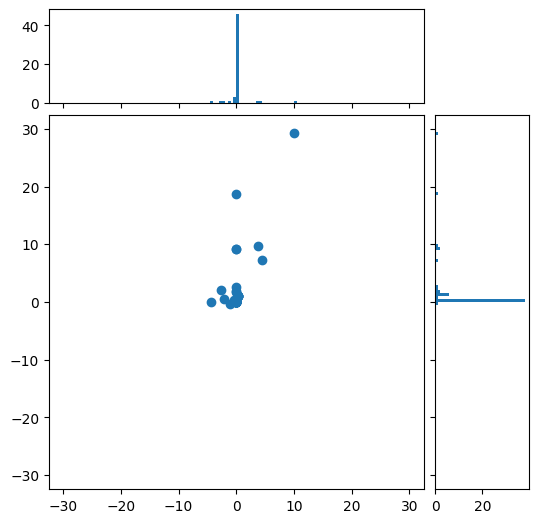

In [14]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.5
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax / binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation="horizontal")


# Start with a square Figure.
fig = pp.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(
    2,
    2,
    width_ratios=(4, 1),
    height_ratios=(1, 4),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.05,
    hspace=0.05,
)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(nad_lower['mitoparp'], nad_upper['mitoparp'], ax, ax_histx, ax_histy)

In [15]:
(fva_lower.iloc[:, :4].abs() + fva_upper.iloc[:, :4].abs()).sum(axis=1).describe()

count     474.000000
mean      413.737469
std      1626.803760
min         0.000000
25%         0.024000
50%         1.288000
75%        10.074750
max      8000.000000
dtype: float64

In [16]:
bound_diff = upper_bounds.iloc[:, :4] - lower_bounds.iloc[:, :4]
for col in ["nad", "nadp", "subsystem"]:
    bound_diff[col] = upper_bounds[col]
bound_diff.to_csv('../results/width_boundaries.csv')
bound_diff.head()

,mitoparp,293,293 + high NAD,mitoparp + high NAD,nad,nadp,subsystem
ACOAHi,1000.0,1000.0,1000.0,1000.0,False,False,Acetate production
ALCD2if,1000.0,1000.0,0.0,0.0,True,False,Alcohol metabolism
ALCD2yf,1000.0,1000.0,0.0,0.0,False,True,Alcohol metabolism
ALDD2x,1000.0,1000.0,0.0,0.0,True,False,Alcohol metabolism
ALDD2xm,1000.0,1000.0,0.0,0.0,True,False,Alcohol metabolism


In [17]:
fva_diff = (fva_upper.iloc[:, :4] - fva_lower.iloc[:, :4])
for col in ['nad', 'nadp', 'subsystem']:
    fva_diff[col] = fva_upper[col]
fva_diff.to_csv("../results/width_fva.csv")
fva_diff.head()

,293,mitoparp,293 + high NAD,mitoparp + high NAD,nad,nadp,subsystem
ACOAHi,0.0,0.01,0.0,0.01,False,False,Acetate production
ALCD2if,0.0,0.00,0.0,0.00,True,False,Alcohol metabolism
ALCD2yf,0.0,0.00,0.0,0.00,False,True,Alcohol metabolism
ALDD2x,0.0,0.00,0.0,0.00,True,False,Alcohol metabolism
ALDD2xm,0.0,0.00,0.0,0.00,True,False,Alcohol metabolism


<Axes: >

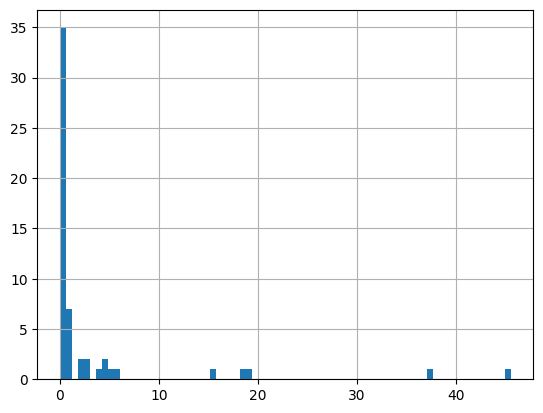

In [18]:
fva_diff[fva_diff.nad].iloc[:, :-3].mean(axis=1).hist(
    bins=75
)

<Axes: >

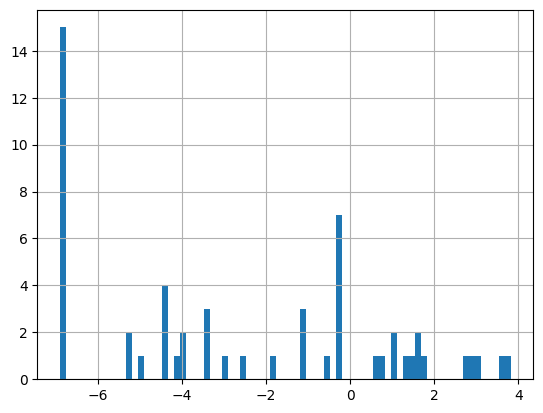

In [19]:
from math import log
safe_log = lambda x: log(x + .001)
fva_diff[fva_diff.nad].iloc[:, :-3].mean(axis=1).map(lambda x: safe_log(x)).hist(bins=75)